# Milestone 3: Predict "missing" wine data

In [1]:
# DL Modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# Import and process the data

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5d5208e600>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5d520bd880>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5d520be330>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5d520bee70>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5d520bf170>,
 'means': []}

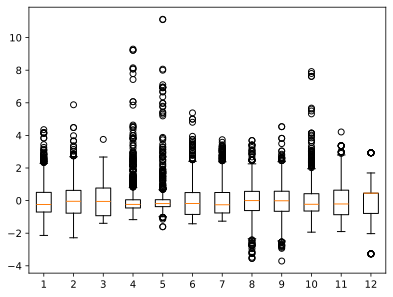

In [13]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns 
data = data.apply(stats.zscore)

# Remove 10 random data values in residual sugar
data.loc[data.sample(10).index, 'residual sugar'] = np.nan

# split the data between rows with nan and without
data_wo_sugar = data[data['residual sugar'].isna()]
data_w_sugar = data[~data['residual sugar'].isna()]

plt.boxplot(data_w_sugar)

# Split the data in Train (with residual sugar) and Test (without residual sugar)

In [14]:
# Step 1: Convert the data to pytorch tensors
tmp_data_w_sugar = data_w_sugar.drop('residual sugar', axis=1)
data_train = torch.tensor(tmp_data_w_sugar.values, dtype=torch.float32)
labels_train = torch.tensor(data_w_sugar['residual sugar'].values, dtype=torch.float32)
labels_train = labels_train[:, None]
data_test = torch.tensor(data_w_sugar.values, dtype=torch.float32)

# Step 2: create the dataset and dataloader
train_dataset = torch.utils.data.TensorDataset(data_train, labels_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, drop_last=True)

print(data_train.shape)
print(labels_train.shape)

torch.Size([1587, 11])
torch.Size([1587, 1])


# We create function that creates the model

In [6]:
def createSugarModel():

    class SugarModel(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input_layer = nn.Linear(11, 16)

            # Hidden layers
            self.hidden1 = nn.Linear(16, 32)
            self.hidden2 = nn.Linear(32, 32)
            # self.hidden3 = nn.Linear(128, 64)
            
            # Output layer
            self.output_layer = nn.Linear(32, 1)

        def forward(self, x):
            x = F.relu(self.input_layer(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            # x = F.relu(self.hidden3(x))
            x = self.output_layer(x)
            return x
        
    net = SugarModel()

    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

# Create a function that trains the model

In [7]:
def trainSugarModel(net, lossfun, optimizer, train_loader, epochs=100):
    losses = []
    trainAcc = []

    for epochi in range(epochs):
        batchLoss = []
        batchAcc = []

        net.train()

        for X,y in train_loader:
            yHat = net(X)

            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            acc = torch.mean(torch.abs(yHat-y))
            batchAcc.append(acc.item())

        losses.append(np.mean(batchLoss))
        trainAcc.append(np.mean(batchAcc))

        # No validation set, so we return what we have 

    return net, losses, trainAcc

# Train the model

In [8]:
sugarModel, lossfun, optimizer = createSugarModel()
sugarModel, losses, trainAcc = trainSugarModel(sugarModel, lossfun, optimizer, train_loader, epochs=500)

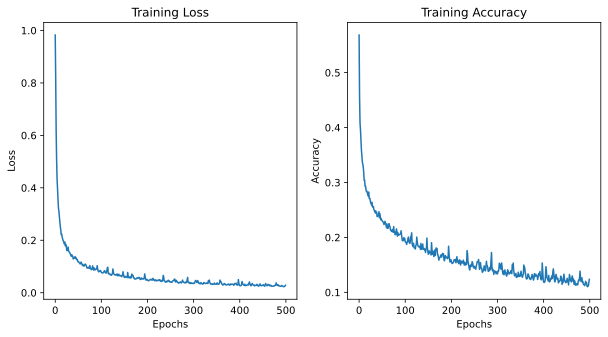

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(trainAcc)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy')

plt.show()

# Predict the missing data and study the correlation

In [22]:
# Predict the missing values 

sugarModel.eval()

predictionTrain = []
predictionTest = []

print(data_wo_sugar.isna().sum())

for i in range(data_w_sugar.shape[0]):
    X = torch.tensor(data_w_sugar.iloc[i].drop('residual sugar').values, dtype=torch.float32)
    prediction = sugarModel(X).item()
    predictionTrain.append(prediction)

for i in range(data_wo_sugar.shape[0]):
    X = torch.tensor(data_wo_sugar.iloc[i].drop('residual sugar').values, dtype=torch.float32)
    prediction = sugarModel(X).item()
    data_wo_sugar.loc[data_wo_sugar.index[i], 'residual sugar'] = prediction
    predictionTest.append(prediction)

print(data_wo_sugar.isna().sum())


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


/tmp/ipykernel_2237039/1251452613.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wo_sugar.loc[data_wo_sugar.index[i], 'residual sugar'] = prediction
/tmp/ipykernel_2237039/1251452613.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wo_sugar.loc[data_wo_sugar.index[i], 'residual sugar'] = prediction
/tmp/ipykernel_2237039/1251452613.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wo_sugar.loc[data_wo_sugar.

In [18]:
# Calculate the correlation of residual sugar with the other variables
# we will do it with original and fake data

og_minus_sugar = data_w_sugar.drop('residual sugar', axis=1)
og_sugar = data_w_sugar['residual sugar']
correlation_og = np.corrcoef(og_minus_sugar, og_sugar, rowvar=False)


fake_minus_sugar = data_wo_sugar.drop('residual sugar', axis=1)
fake_sugar = data_wo_sugar['residual sugar']
correlation_fake = np.corrcoef(fake_minus_sugar, fake_sugar, rowvar=False)

print(correlation_og[1][0]) # correlation between og_sugar (1) and all other values (0)
print(correlation_fake[1][0]) # correlation between fake_sugar (1) and all other values (0)


-0.25436814793877727
-0.40243972522966875


Text(0.5, 1.0, 'Predicted vs Actual')

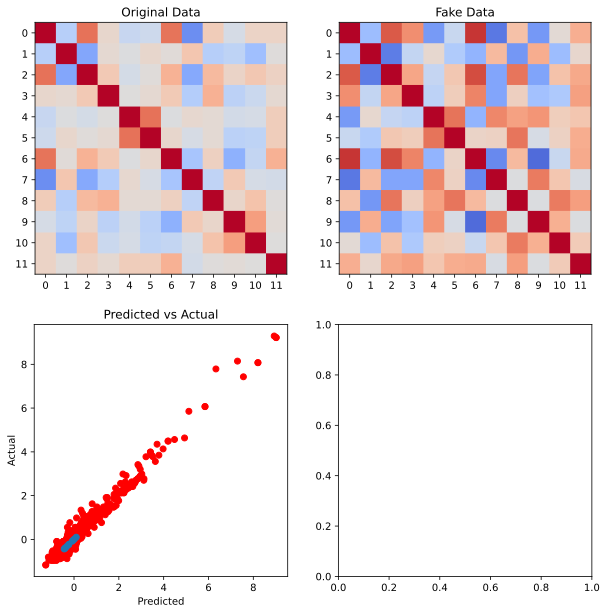

In [28]:
# plot the correlation matrices
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].imshow(correlation_og, cmap='coolwarm', vmin=-1, vmax=1)
ax[0][0].set_title('Original Data')
ax[0][0].set_xticks(range(12))
ax[0][0].set_yticks(range(12))

ax[0][1].imshow(correlation_fake, cmap='coolwarm', vmin=-1, vmax=1)
ax[0][1].set_title('Fake Data')
ax[0][1].set_xticks(range(12))
ax[0][1].set_yticks(range(12))

ax[1][0].plot(predictionTrain, data_w_sugar['residual sugar'], 'ro')
ax[1][0].plot(predictionTest, data_wo_sugar['residual sugar'], 'o')
ax[1][0].set_xlabel('Predicted')
ax[1][0].set_ylabel('Actual')
ax[1][0].set_title('Predicted vs Actual')